In [13]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='browser'
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [14]:
density_data = pd.read_csv("../Curated_data/cluster_0_data.csv", low_memory=False)


In [15]:
mineral = 'Density_gcm3'
filter = ['Sulph1_Code', 'Sulph1_Pct', 'Sulph2_Code', 'Sulph2_Pct']
deposit_data = density_data

deposit_data = deposit_data.dropna(subset=[mineral] + filter)
df1 = deposit_data
variable=mineral

In [16]:
two_composite_1covariates = deposit_data

# Calculate the percentage of missing values for each variable
missing_percentage = (two_composite_1covariates.isnull().sum() / len(two_composite_1covariates)) * 100

# Identify variables with more than 15% missing values
variables_to_remove = missing_percentage[missing_percentage > 5].index

# Drop the identified variables from the DataFrame
two_composite_1covariates = two_composite_1covariates.drop(columns=variables_to_remove)


encoded_data = two_composite_1covariates.copy()

threshold = 10

for column in two_composite_1covariates.columns:
    if two_composite_1covariates[column].dtype == 'object':
        unique_values = two_composite_1covariates[column].nunique()
        
        # Check if the number of unique values is within the threshold
        if unique_values <= threshold:
            # Perform one-hot encoding for columns with unique values within the threshold
            encoded_columns = pd.get_dummies(encoded_data[column], prefix=column)
            encoded_columns = encoded_columns.astype(int)  # Convert to integers (0 or 1)
            encoded_data = pd.concat([encoded_data, encoded_columns], axis=1)
            encoded_data = encoded_data.drop(columns=[column])




# Identify the encoded columns based on the common pattern
encoded_columns = [col for col in encoded_data.columns if '_Code_' in col]

# List to store the total columns
total_columns = []

# Iterate through the encoded columns and calculate the total for each category
for col in encoded_columns:
    # Extract the prefix and original column name
    prefix, original_column = col.split('_Code_')
    
    # Calculate the total for the category
    total_column = f"{original_column}_Total"
    total_columns.append(total_column)
    
    # Multiply the code column by the corresponding percentage column and sum them
    encoded_data[total_column] = (
        encoded_data[f"{prefix}_Code_{original_column}"] * encoded_data[f"{prefix}_Pct"]
    )

# List to store the total columns
total_columns = []

# Initialize a dictionary to accumulate totals for each category
category_totals = {}

# Iterate through the encoded columns and calculate the total for each category
for col in encoded_columns:
    # Extract the prefix and original column name
    prefix, original_column = col.split('_Code_')
    
    # Calculate the total for the category
    total_column = f"{original_column}_Total"
    if total_column not in total_columns:
        total_columns.append(total_column)
    
    # Multiply the code column by the corresponding percentage column
    total_values = encoded_data[f"{prefix}_Code_{original_column}"] * encoded_data[f"{prefix}_Pct"]
    
    # Accumulate the totals for each category
    if total_column in category_totals:
        category_totals[total_column] += total_values
    else:
        category_totals[total_column] = total_values

# Add accumulated totals to the DataFrame
for total_column, total_values in category_totals.items():
    encoded_data[total_column] = total_values


In [17]:
variable_names = ['Sc_ppm',
 'Al_pct',
 'Y_ppm',
 'V_ppm',
 'Sr_ppm',
 'Ca_pct',
 'P_ppm',
 'Si_pct',
 'Li_ppm',
 'Mg_pct',
 'La_ppm',
 'RQD_Pct',
 'Alt1_Int_wk',
 'Ba_ppm',
 'Sulph1_Code_PO',
 'IP_pct',
 'Sulph2_Code_CP',
 'Sulph2_Code_PO',
 'X',
 'PY_Total',
 'Z',
 'PO_Total',
 'CP_Total',
 'Cr_ppm',
 'B_ppm',
 'Y',
 'Sb_ppm',
 'Weathering']

In [18]:
filtered_encoded_data = encoded_data[encoded_data.columns.intersection(variable_names+ ['Density_gcm3', 'Name'])]

deposit_data = encoded_data[['Name', 'X', 'Y', 'Z', 'Density_gcm3', 'RQD_Pct', 'Cr_ppm', 'CP_Total',
       'PO_Total', 'PY_Total']]
total_columns = ['CP_Total','PO_Total', 'PY_Total']
covariates = total_columns[:3] + ['RQD_Pct', 'Cr_ppm']

deposit_data.describe()
deposit_data.fillna(0, inplace=True)
deposit_data

C:\Users\23478671\AppData\Local\Temp\ipykernel_11152\3867690008.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Name,X,Y,Z,Density_gcm3,RQD_Pct,Cr_ppm,CP_Total,PO_Total,PY_Total
393,KV-NME001,3498922.13,7511747.51,148.80,3.13,88.00,212.6,1.0,1.0,0.0
394,KV-NME001,3498922.68,7511747.45,146.88,3.15,88.00,268.0,1.0,1.0,0.0
434,KV-NME001,3498945.16,7511745.25,70.14,3.22,99.00,215.0,1.0,1.0,0.0
435,KV-NME001,3498945.73,7511745.20,68.22,3.22,99.00,236.0,1.5,2.0,0.0
436,KV-NME001,3498946.29,7511745.15,66.30,3.22,99.00,256.0,2.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...
81071,KV365,3499347.52,7510618.17,85.03,3.44,92.35,131.0,0.2,3.0,0.0
81072,KV365,3499347.32,7510617.19,83.30,3.43,92.35,125.0,0.2,3.0,0.0
81073,KV365,3499347.13,7510616.22,81.56,3.44,85.84,128.0,0.2,3.0,0.0
81074,KV365,3499346.93,7510615.24,79.83,3.40,85.84,129.0,0.2,3.0,0.0


In [19]:
# Define the columns to normalize
columns_to_normalize = ['X', 'Y', 'Z']   # Add all columns you want to normalize

min_values = deposit_data[columns_to_normalize].min()

for column in columns_to_normalize:
    deposit_data[column] = deposit_data[column] - min_values[column]

# Calculate the minimum and maximum values from the entire dataset
min_values = deposit_data[columns_to_normalize].min().min()
max_values = deposit_data[columns_to_normalize].max().max()

# Scale the data to (0, 1) using the calculated minimum and maximum values
for column in columns_to_normalize:
    deposit_data[column] = (deposit_data[column] - min_values) / (max_values - min_values)

scaler = MinMaxScaler()
deposit_data.loc[:, [mineral] +covariates] = scaler.fit_transform(deposit_data.loc[:,[mineral] + covariates])


C:\Users\23478671\AppData\Local\Temp\ipykernel_11152\1488387108.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23478671\AppData\Local\Temp\ipykernel_11152\1488387108.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23478671\AppData\Local\Temp\ipykernel_11152\1488387108.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [20]:
# lon = df1.values[:,4]
# lat = df1.values[:,5]
# az = df1.values[:,6]

# normalized_lon = (lon-min(lon))/(max(lon)-min(lon))
# normalized_lat = (lat-min(lat))/(max(lat)-min(lat))
# normalized_az = (az-min(az))/(max(az)-min(az))
# N = lon.shape[0]

In [21]:

lon = df1.values[:, 4]
lat = df1.values[:, 5]
az = df1.values[:, 6]

# Subtract the minimum values for each array
lon = lon - np.min(lon)
lat = lat - np.min(lat)
az = az - np.min(az)

# Calculate the overall minimum and maximum values from the entire dataset
min_value = np.min([np.min(lon), np.min(lat), np.min(az)])
max_value = np.max([np.max(lon), np.max(lat), np.max(az)])

# Scale the arrays to (0, 1) using the calculated minimum and maximum values
normalized_lon = (lon - min_value) / (max_value - min_value)
normalized_lat = (lat - min_value) / (max_value - min_value)
normalized_az = (az - min_value) / (max_value - min_value)

N = lon.shape[0]

# Display the normalized arrays
print("Normalized Lon:", normalized_lon)
print("Normalized Lat:", normalized_lat)
print("Normalized Az:", normalized_az)


Normalized Lon: [0.43781378776682156 0.43806121898106964 0.4481744075146454 ...
 0.6290106350432114 0.6289206600563835 0.6288351838188028]
Normalized Lat: [0.5098162710765618 0.5097892785806601 0.5087995537240868 ...
 0.0008772561228813492 0.0004363786870266015 0.0]
Normalized Az: [0.46145471558890383 0.4605909557141493 0.42606755322005485 ...
 0.4312051249751051 0.43042684133795656 0.4296440589514603]


In [22]:
num_basis = [10**3,19**3,37**3]
knots_1dx = [np.linspace(0,1,int(i**(1/3))+1) for i in num_basis]
knots_1dy = [np.linspace(0,1,int(i**(1/3))+1) for i in num_basis]
knots_1dz = [np.linspace(0,1,int(i**(1/3))+1) for i in num_basis]


##Wendland kernel
basis_size = 0
phi = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/(num_basis[res]**(1/3))*2.5
    knots_x, knots_y, knots_z = np.meshgrid(knots_1dx[res],knots_1dy[res], knots_1dz[res])
    knots = np.column_stack((knots_x.flatten(),knots_y.flatten(),knots_z.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(np.vstack((normalized_lon,normalized_lat, normalized_az)).astype(float).T-knots[i,:],axis=1)/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + basis_size] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + basis_size] = 0
    basis_size = basis_size + num_basis[res]

In [23]:
## Romove the all-zero columns
idx_zero = np.array([], dtype=int)
for i in range(phi.shape[1]):
    if sum(phi[:,i]!=0)==0:
        idx_zero = np.append(idx_zero,int(i))

phi_reduce = np.delete(phi,idx_zero,1)
print(phi.shape)
print(phi_reduce.shape)

(2618, 58512)
(2618, 6403)


In [33]:

len_phi = np.shape(phi_reduce)[1]

# Create a DataFrame
df = pd.DataFrame(phi_reduce, columns=[f'phi_{i}' for i in range(len_phi)])

# Display the DataFrame
print(df)


      phi_0  phi_1  phi_2  phi_3  phi_4  phi_5  phi_6     phi_7     phi_8  \
0       0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000  0.000000   
1       0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000  0.000000   
2       0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000  0.000000   
3       0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000  0.000000   
4       0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000  0.000000   
...     ...    ...    ...    ...    ...    ...    ...       ...       ...   
2613    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000246  0.003618   
2614    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000262  0.003631   
2615    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000279  0.003641   
2616    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000297  0.003651   
2617    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000315  0.003659   

         phi_9  ...  phi_6393  phi_6394  phi_6395  phi_6396  phi_6397  \
0 

In [34]:
df_reset = df.reset_index(drop=True)
deposit_data_reset = deposit_data.reset_index(drop=True)

# Concatenate along columns
deposit_data = pd.concat([deposit_data_reset, df], axis=1)

# Display the resulting DataFrame
deposit_data

,Name,X,Y,Z,Density_gcm3,RQD_Pct,Cr_ppm,CP_Total,PO_Total,PY_Total,...,phi_6393,phi_6394,phi_6395,phi_6396,phi_6397,phi_6398,phi_6399,phi_6400,phi_6401,phi_6402
0,KV-NME001,0.437814,0.509816,0.461455,0.400922,0.8800,0.127305,0.250,0.066667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,KV-NME001,0.438061,0.509789,0.460591,0.410138,0.8800,0.160479,0.250,0.066667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,KV-NME001,0.448174,0.508800,0.426068,0.442396,0.9900,0.128743,0.250,0.066667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,KV-NME001,0.448431,0.508777,0.425204,0.442396,0.9900,0.141317,0.375,0.133333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,KV-NME001,0.448683,0.508755,0.424340,0.442396,0.9900,0.153293,0.500,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2613,KV365,0.629186,0.001755,0.432766,0.543779,0.9235,0.078443,0.050,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2614,KV365,0.629096,0.001314,0.431988,0.539171,0.9235,0.074850,0.050,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2615,KV365,0.629011,0.000877,0.431205,0.543779,0.8584,0.076647,0.050,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2616,KV365,0.628921,0.000436,0.430427,0.525346,0.8584,0.077246,0.050,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# Assuming deposit_data is your DataFrame
# Extract the names of the first 98 columns
phi_columns = deposit_data.columns[10:].tolist()

# Display the list of column names
print(phi_columns[:10])


['phi_0', 'phi_1', 'phi_2', 'phi_3', 'phi_4', 'phi_5', 'phi_6', 'phi_7', 'phi_8', 'phi_9']


In [36]:
deposit_data = deposit_data.dropna(subset=['Density_gcm3'] + covariates + phi_columns)

C:\Users\23478671\AppData\Local\Temp\ipykernel_11152\146396046.py:27: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\23478671\AppData\Local\Temp\ipykernel_11152\146396046.py:28: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\23478671\AppData\Local\Temp\ipykernel_11152\146396046.py:29: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\23478671\AppData\Local\Temp\ipykernel_11152\146396046.py:30: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

- Iteration 0, MSE: 0.6619
- Iteration 100, MSE: 0.0119
- Iteration 200, MSE: 0.0062
- Iteration 300, MSE: 0.0044
- Iteration 400, MSE: 0.0036
- Iteration 500, MSE: 0.0032
- Iteration 600, MSE: 0.0027


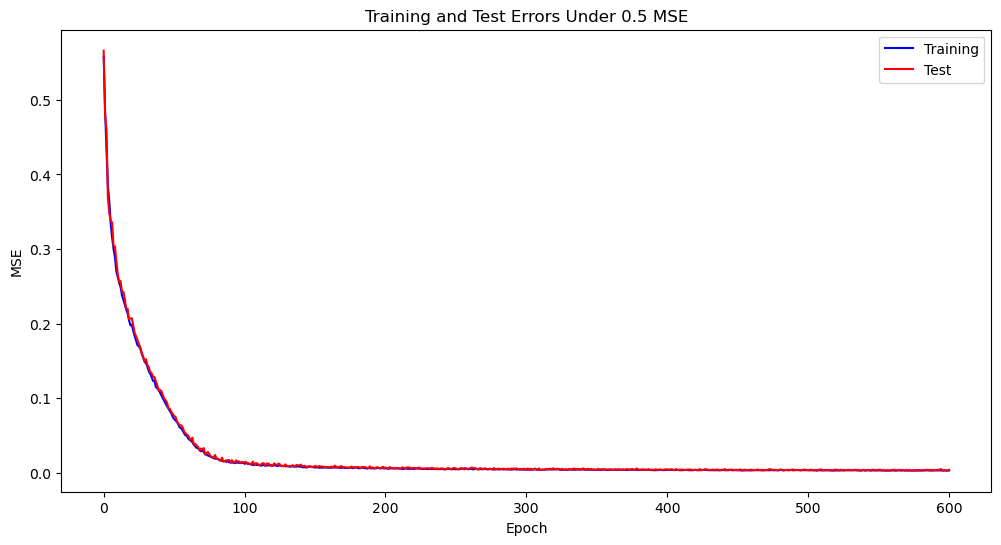

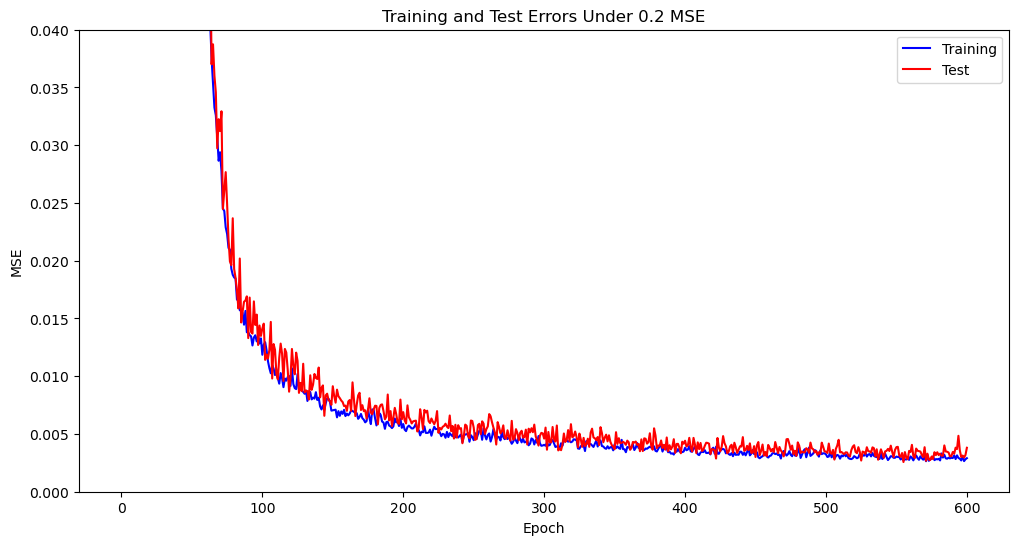

In [40]:
p = len(phi_columns) + len(covariates)

x = deposit_data[phi_columns + covariates].values #[:,np.newaxis] makes the second dimension explicit
y = deposit_data[[variable]].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
x = x.reshape(len(deposit_data),p)
x = x[:,[i for i in range(p)]]

x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)


# Determine the size of the test set (e.g., 20% of the data)
test_size = int(0.2 * len(x))

# Generate random indices for the test set
test_indices = np.random.choice(len(x), size=test_size, replace=False)

# Create train and test sets based on the indices
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# model = nn.Sequential(
#     nn.Linear(in_features=p, out_features=1000),
#     nn.ReLU(),
#     nn.Linear(in_features=1000, out_features=1)
# )

model = nn.Sequential(
    nn.Linear(in_features=p, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5) ,
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=1))


mse_loss = nn.MSELoss()
#Apparently lr=0.005 is better than 0.01 and than 0.001: quicker and better convergence
#optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

for step in range(601):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    pre_train = model(x_train)
    mse_train = mse_loss(pre_train, y_train)
    train_losses.append(mse_train.item())

    # Evaluate the model on the test set
    pre_test = model(x_test)
    mse_test = mse_loss(pre_test, y_test)
    test_losses.append(mse_test.item())

    if step % 100 == 0:
        print(f'- Iteration {step}, MSE: {mse.item():.4f}')




# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
#plt.ylim(0, 0.5)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.5 MSE')
plt.show()



# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.04)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.2 MSE')
plt.show()








In [41]:
# Function to print evaluation metrics
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

torch.manual_seed(42)
np.random.seed(42)

# Assuming deposit_data, covariates, and other necessary variables are defined

# Create an array to store metrics for each fold
test_mse_list = []
test_rmse_list = []
test_mae_list = []
test_r2_list = []



# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(deposit_data)):
    train_data, test_data = deposit_data.iloc[train_index], deposit_data.iloc[test_index]

    x_train = train_data[phi_columns + covariates].values
    y_train = train_data['Density_gcm3'].values

    x_test = test_data[phi_columns + covariates].values
    y_test = test_data['Density_gcm3'].values

    # Define your neural network
    model = nn.Sequential(
        nn.Linear(in_features=p, out_features=100),
        nn.ReLU(),
        nn.Dropout(0.5) ,
        nn.BatchNorm1d(100),
        nn.Linear(in_features=100, out_features=100),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(in_features=100, out_features=100),
        nn.ReLU(),
        nn.BatchNorm1d(100),
        nn.Linear(in_features=100, out_features=1))


    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    # Training loop
    for step in range(601):
        pre = model(torch.tensor(x_train, dtype=torch.float32))
        mse = mse_loss(pre, torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32))
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        pre_test = model(torch.tensor(x_test, dtype=torch.float32))
        mse_test = mse_loss(pre_test, torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32))
        test_losses.append(mse_test.item())

    # Store metrics for this fold
    test_predictions_fold = model(torch.tensor(x_test, dtype=torch.float32)).detach().numpy().flatten()
    test_mse_list.append(mean_squared_error(y_test, test_predictions_fold))
    test_mae_list.append(mean_absolute_error(y_test, test_predictions_fold))
    test_r2_list.append(r2_score(y_test, test_predictions_fold))

    # Print metrics for the current fold
    print(f"\nMetrics for Fold {fold + 1}:")
    print_metrics(y_test, test_predictions_fold, "Test")

# Print average metrics across folds
print("\nAverage Metrics Across Folds:")
print(f"  Average MSE: {np.mean(test_mse_list):.4f}")
print(f"  Average MAE: {np.mean(test_mae_list):.4f}")
print(f"  STD MAE: {np.std(test_mae_list):.4f}")

print(f"  STD MSE: {np.std(test_mse_list):.4f}")



Metrics for Fold 1:
Metrics for Test set:
  MSE: 0.0031
  RMSE: 0.0561
  MAE: 0.0405
  R^2: 0.8029


Metrics for Fold 2:
Metrics for Test set:
  MSE: 0.0031
  RMSE: 0.0558
  MAE: 0.0364
  R^2: 0.7624


Metrics for Fold 3:
Metrics for Test set:
  MSE: 0.0033
  RMSE: 0.0578
  MAE: 0.0409
  R^2: 0.7733


Metrics for Fold 4:
Metrics for Test set:
  MSE: 0.0029
  RMSE: 0.0536
  MAE: 0.0395
  R^2: 0.7872


Metrics for Fold 5:
Metrics for Test set:
  MSE: 0.0035
  RMSE: 0.0591
  MAE: 0.0407
  R^2: 0.8057


Metrics for Fold 6:
Metrics for Test set:
  MSE: 0.0028
  RMSE: 0.0526
  MAE: 0.0379
  R^2: 0.7825


Metrics for Fold 7:
Metrics for Test set:
  MSE: 0.0029
  RMSE: 0.0539
  MAE: 0.0413
  R^2: 0.8391


Metrics for Fold 8:
Metrics for Test set:
  MSE: 0.0025
  RMSE: 0.0498
  MAE: 0.0368
  R^2: 0.8621


Metrics for Fold 9:
Metrics for Test set:
  MSE: 0.0034
  RMSE: 0.0585
  MAE: 0.0414
  R^2: 0.7303


Metrics for Fold 10:
Metrics for Test set:
  MSE: 0.0039
  RMSE: 0.0624
  MAE: 0.0463
  R^

THIS IS W the 2 covaraites, no suplhides
\
Average Metrics Across Folds:
\
  Average MSE: 0.0033 
  \
  Average MAE: 0.0403 
  \
  STD MAE: 0.0027
  \
  STD MSE: 0.0005

THIS IS W THE 5 covariates, WITH sulphides:
\
Average Metrics Across Folds:
\
  Average MSE: 0.0031
  \
  Average MAE: 0.0392
  \
  STD MAE: 0.0028
  \
  STD MSE: 0.0004

THIS IS W THE 5 covariates, WITH sulphides AND normalising to keep distances:
\
Average Metrics Across Folds:
\
  Average MSE: 0.0031
  \
  Average MAE: 0.0392
  \
  STD MAE: 0.0028
  \
  STD MSE: 0.0004